In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

In [2]:
ensemble_product = 'mean'

In [3]:
lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002

Tr = [5.,  10.,  20.,  50., 100., 200.]

In [4]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    REGIONS = gpd.read_file(os.path.join(veneto_dir,'Italy_regions.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'DEM','Italy_dem_800.geojson'))   
else:
    raise SystemExit(f"File not found: {veneto_dir}")

# update name of REGIONS geopandas
REGIONS = REGIONS.rename(columns={"reg_name": "Region"})
REGIONS['Region'] = REGIONS['Region'].replace('Emilia Romagna', 'Emilia-Romagna')

In [5]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges', 'QC_MIX')

In [6]:
ISO_names = pd.read_csv(os.path.join('/','media','arturo','T9','Data','Italy', 'stations', 'Italy_raingauges', 'ISO_IT_REGION_EN.csv'))

In [7]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [8]:
def clear_dict(product, font='DOWN'):
    
    if product != 'ensemble':
        dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{product}_{font}_elev.csv')
        ELEV_dict = pd.read_csv(dir_in)

        dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{product}_{font}_Q50_OBS.csv')
        OBS_dict = pd.read_csv(dir_in)

        dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'{product}_{font}_Q50_VAL.csv')
        SAT_dict = pd.read_csv(dir_in)
    else:
        dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ENSEMBLE_{font}_elev.csv')
        ELEV_dict = pd.read_csv(dir_in)

        dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ENSEMBLE_{font}_Q50_OBS.csv')
        OBS_dict = pd.read_csv(dir_in)

        dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ENSEMBLE_{font}_Q50_VAL.csv')
        SAT_dict = pd.read_csv(dir_in)
    
    OBS_elev_flat = ELEV_dict.values.flatten()
    OBS_Q50_flat = OBS_dict.values.flatten()
    SAT_Q50_flat = SAT_dict.values.flatten()

    mask = np.where((~np.isnan(OBS_elev_flat))&(~np.isnan(OBS_Q50_flat))&(~np.isnan(SAT_Q50_flat)))

    OBS_elev_clear = OBS_elev_flat[mask]
    OBS_Q50_clear = OBS_Q50_flat[mask]
    SAT_Q50_clear = SAT_Q50_flat[mask]    
    
    sort_idx = np.argsort(OBS_elev_clear)
    OBS_elev_sorted = OBS_elev_clear[sort_idx]
    OBS_Q50_sorted = OBS_Q50_clear[sort_idx]
    SAT_Q50_sorted = SAT_Q50_clear[sort_idx]

    OBS_elev_norm = (OBS_elev_sorted-np.min(OBS_elev_sorted))/(np.max(OBS_elev_sorted)-np.min(OBS_elev_sorted))*30
    
    return OBS_elev_sorted, OBS_Q50_sorted, SAT_Q50_sorted, OBS_elev_norm

def linear_regression(OBS, DOWN):
    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    # Obtener el slope (pendiente)
    slope = reg.coef_[0]
    intercept = reg.intercept_
    
    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)

    return x_line, y_line, slope

In [9]:
CMORPH_DOWN_elev, CMORPH_DOWN_Q50_OBS, CMORPH_DOWN_Q50_VAL, CMORPH_DOWN_ELEV_norm = clear_dict('CMORPH', font='DOWN')
ERA5_DOWN_elev, ERA5_DOWN_Q50_OBS, ERA5_DOWN_Q50_VAL, ERA5_DOWN_ELEV_norm = clear_dict('ERA5', font='DOWN')
GSMaP_DOWN_elev, GSMaP_DOWN_Q50_OBS, GSMaP_DOWN_Q50_VAL, GSMaP_DOWN_ELEV_norm = clear_dict('GSMaP', font='DOWN')
MSWEP_DOWN_elev, MSWEP_DOWN_Q50_OBS, MSWEP_DOWN_Q50_VAL, MSWEP_DOWN_ELEV_norm = clear_dict('MSWEP', font='DOWN')
IMERG_DOWN_elev, IMERG_DOWN_Q50_OBS, IMERG_DOWN_Q50_VAL, IMERG_DOWN_ELEV_norm = clear_dict('IMERG', font='DOWN')
CHIRPS_DOWN_elev, CHIRPS_DOWN_Q50_OBS, CHIRPS_DOWN_Q50_VAL, CHIRPS_DOWN_ELEV_norm = clear_dict('CHIRPS', font='DOWN')

ENSEMBLE_DOWN_elev, ENSEMBLE_DOWN_Q50_OBS, ENSEMBLE_DOWN_Q50_VAL, ENSEMBLE_DOWN_ELEV_norm = clear_dict('ensemble', font='DOWN')

In [10]:
CMORPH_SAT_elev, CMORPH_SAT_Q50_OBS, CMORPH_SAT_Q50_VAL, CMORPH_SAT_ELEV_norm = clear_dict('CMORPH', font='SAT')
ERA5_SAT_elev, ERA5_SAT_Q50_OBS, ERA5_SAT_Q50_VAL, ERA5_SAT_ELEV_norm = clear_dict('ERA5', font='SAT')
GSMaP_SAT_elev, GSMaP_SAT_Q50_OBS, GSMaP_SAT_Q50_VAL, GSMaP_SAT_ELEV_norm = clear_dict('GSMaP', font='SAT')
MSWEP_SAT_elev, MSWEP_SAT_Q50_OBS, MSWEP_SAT_Q50_VAL, MSWEP_SAT_ELEV_norm = clear_dict('MSWEP', font='SAT')
IMERG_SAT_elev, IMERG_SAT_Q50_OBS, IMERG_SAT_Q50_VAL, IMERG_SAT_ELEV_norm = clear_dict('IMERG', font='SAT')
CHIRPS_SAT_elev, CHIRPS_SAT_Q50_OBS, CHIRPS_SAT_Q50_VAL, CHIRPS_SAT_ELEV_norm = clear_dict('CHIRPS', font='SAT')

ENSEMBLE_SAT_elev, ENSEMBLE_SAT_Q50_OBS, ENSEMBLE_SAT_Q50_VAL, ENSEMBLE_SAT_ELEV_norm = clear_dict('ensemble', font='SAT')

In [11]:
IMERG_DOWN_x, IMERG_DOWN_y, IMERG_slope = linear_regression(IMERG_DOWN_Q50_OBS, IMERG_DOWN_Q50_VAL)
CMORPH_DOWN_x, CMORPH_DOWN_y, CMORPH_slope = linear_regression(CMORPH_DOWN_Q50_OBS, CMORPH_DOWN_Q50_VAL)
ERA5_DOWN_x, ERA5_DOWN_y, ERA5_slope = linear_regression(ERA5_DOWN_Q50_OBS, ERA5_DOWN_Q50_VAL)
GSMaP_DOWN_x, GSMaP_DOWN_y, GSMaP_slope = linear_regression(GSMaP_DOWN_Q50_OBS, GSMaP_DOWN_Q50_VAL)
MSWEP_DOWN_x, MSWEP_DOWN_y, MSWEP_slope = linear_regression(MSWEP_DOWN_Q50_OBS, MSWEP_DOWN_Q50_VAL)
CHIRPS_DOWN_x, CHIRPS_DOWN_y, CHIRPS_slope = linear_regression(CHIRPS_DOWN_Q50_OBS, CHIRPS_DOWN_Q50_VAL)
ENSEMBLE_DOWN_x, ENSEMBLE_DOWN_y, ENSEMBLE_slope = linear_regression(ENSEMBLE_DOWN_Q50_OBS, ENSEMBLE_DOWN_Q50_VAL)

In [12]:
# correlation between CMORPH_OBS_Q50 and CMORPH_DOWN_Q50
corr_CMORPH_D, _ = pearsonr(CMORPH_DOWN_Q50_OBS, CMORPH_DOWN_Q50_VAL)
corr_ERA5_D, _ = pearsonr(ERA5_DOWN_Q50_OBS, ERA5_DOWN_Q50_VAL)
corr_GSMaP_D, _ = pearsonr(GSMaP_DOWN_Q50_OBS, GSMaP_DOWN_Q50_VAL)
corr_MSWEP_D, _ = pearsonr(MSWEP_DOWN_Q50_OBS, MSWEP_DOWN_Q50_VAL)
corr_IMERG_D, _ = pearsonr(IMERG_DOWN_Q50_OBS, IMERG_DOWN_Q50_VAL)
corr_CHIRPS_D, _ = pearsonr(CHIRPS_DOWN_Q50_OBS, CHIRPS_DOWN_Q50_VAL)
corr_ENSEMBLE_D, _ = pearsonr(ENSEMBLE_DOWN_Q50_OBS, ENSEMBLE_DOWN_Q50_VAL)

print(f'CMORPH correlation: {np.round(corr_CMORPH_D,2)}')
print(f'ERA5 correlation: {np.round(corr_ERA5_D,2)}')
print(f'GSMaP correlation: {np.round(corr_GSMaP_D,2)}')
print(f'MSWEP correlation: {np.round(corr_MSWEP_D,2)}')
print(f'IMERG correlation: {np.round(corr_IMERG_D,2)}')
print(f'CHIRPS correlation: {np.round(corr_CHIRPS_D,2)}')
print(f'ENSEMBLE correlation: {np.round(corr_ENSEMBLE_D,2)}')

CMORPH correlation: 0.5
ERA5 correlation: 0.63
GSMaP correlation: 0.43
MSWEP correlation: 0.59
IMERG correlation: 0.61
CHIRPS correlation: 0.4
ENSEMBLE correlation: 0.52


In [13]:
val_remove = 500
vmin = ENSEMBLE_DOWN_elev.min()
vmax = ENSEMBLE_DOWN_elev.max()
vmin, vmax

(np.float64(-3.0), np.float64(3013.10009765625))

../figures/Article_down/Products_DOWN_Scatter.png


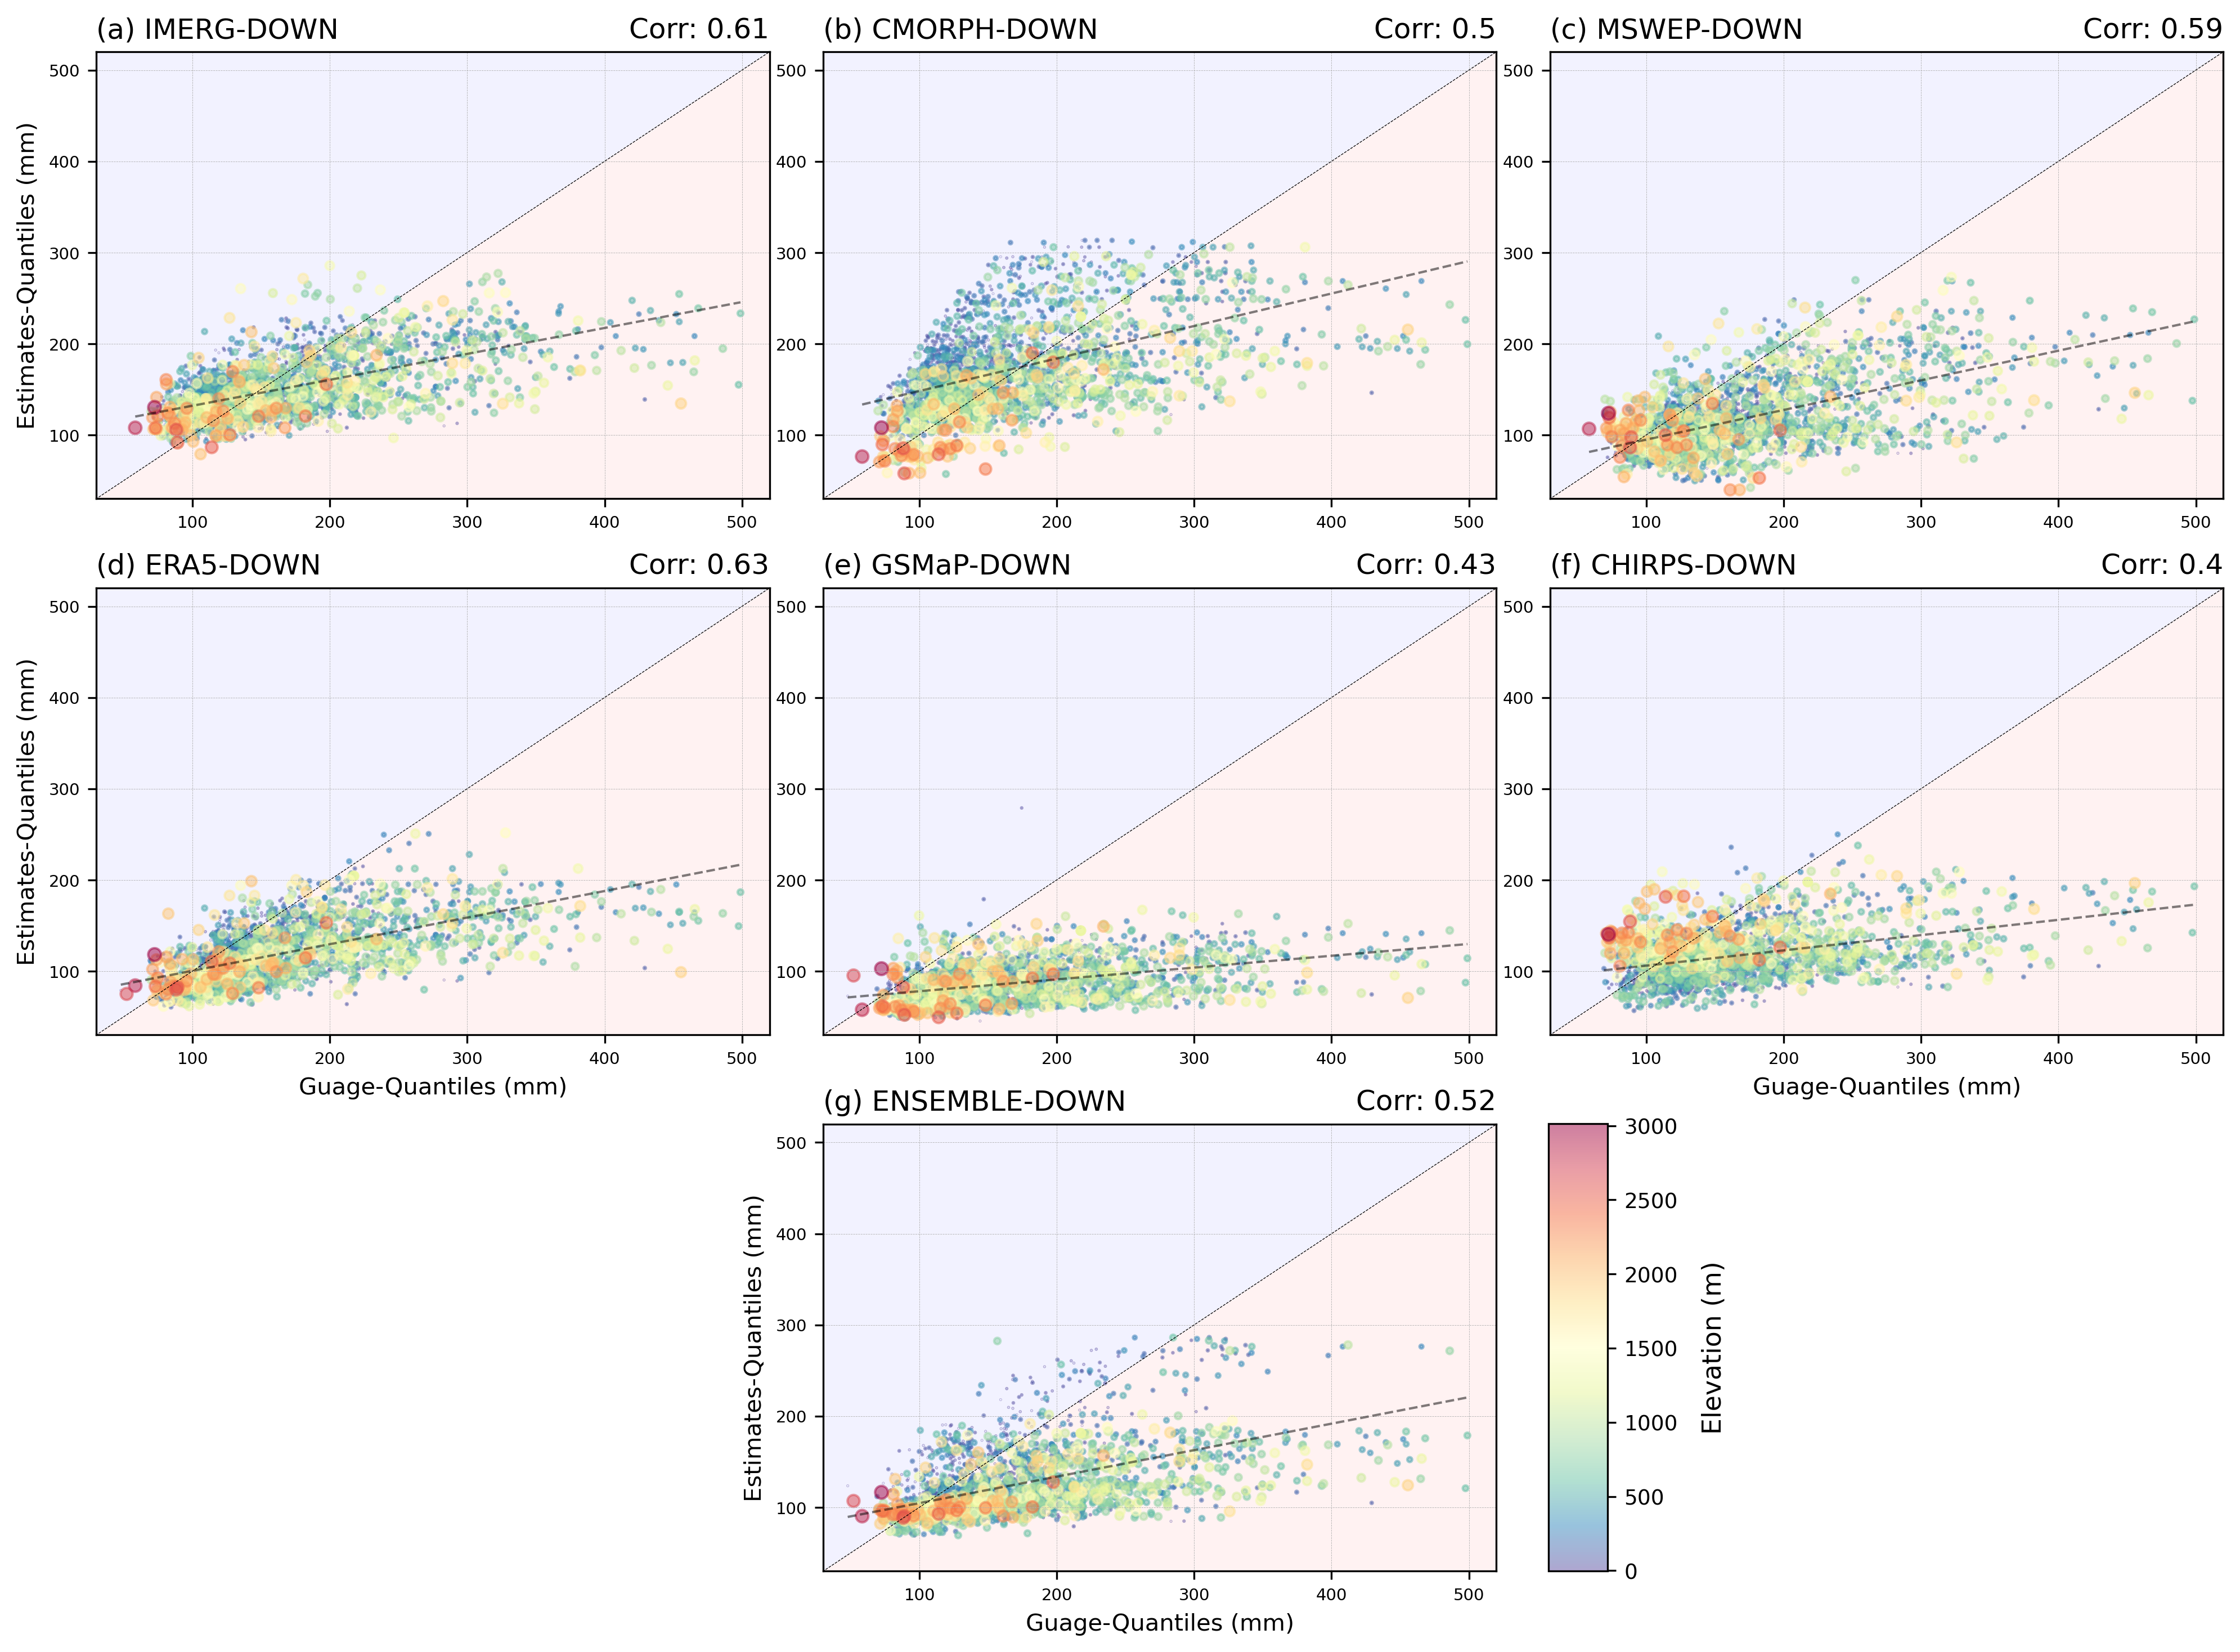

In [14]:
fig = plt.figure(figsize=(14,10),dpi=300)
gs = gridspec.GridSpec(3,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    IMERG_DOWN_Q50_OBS, IMERG_DOWN_Q50_VAL,
    alpha=0.5,
    s=IMERG_DOWN_ELEV_norm,
    c=IMERG_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(IMERG_DOWN_x, IMERG_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(a) IMERG-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_IMERG_D,2)}', loc='right', fontsize=12)
ax1.set_ylabel('Estimates-Quantiles (mm)',fontsize=10)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    CMORPH_DOWN_Q50_OBS, CMORPH_DOWN_Q50_VAL,
    alpha=0.5,
    s=CMORPH_DOWN_ELEV_norm,
    c=CMORPH_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(CMORPH_DOWN_x, CMORPH_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(b) CMORPH-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_CMORPH_D,2)}', loc='right', fontsize=12)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    MSWEP_DOWN_Q50_OBS, MSWEP_DOWN_Q50_VAL,
    alpha=0.5,
    s=MSWEP_DOWN_ELEV_norm,
    c=MSWEP_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(MSWEP_DOWN_x, MSWEP_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(c) MSWEP-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_MSWEP_D,2)}', loc='right', fontsize=12)

# ============================================================================================================================
# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    ERA5_DOWN_Q50_OBS, ERA5_DOWN_Q50_VAL,
    alpha=0.5,
    s=ERA5_DOWN_ELEV_norm,
    c=ERA5_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(ERA5_DOWN_x, ERA5_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(d) ERA5-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_ERA5_D,2)}', loc='right', fontsize=12)
ax1.set_ylabel('Estimates-Quantiles (mm)',fontsize=10)
ax1.set_xlabel('Guage-Quantiles (mm)',fontsize=10)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    GSMaP_DOWN_Q50_OBS, GSMaP_DOWN_Q50_VAL,
    alpha=0.5,
    s=GSMaP_DOWN_ELEV_norm,
    c=GSMaP_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(GSMaP_DOWN_x, GSMaP_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(e) GSMaP-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_GSMaP_D,2)}', loc='right', fontsize=12)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    CHIRPS_DOWN_Q50_OBS, CHIRPS_DOWN_Q50_VAL,
    alpha=0.5,
    s=CHIRPS_DOWN_ELEV_norm,
    c=CHIRPS_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(CHIRPS_DOWN_x, CHIRPS_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(f) CHIRPS-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_CHIRPS_D,2)}', loc='right', fontsize=12)
ax1.set_xlabel('Guage-Quantiles (mm)',fontsize=10)

# ============================================================================================================================
ax1 = plt.subplot(gs[2, 1])
ax1.plot(np.arange(val_remove+20),np.arange(val_remove+20),'--k', linewidth=0.3, label='Identity line')

ax1.scatter([],[], s=5, c='darkred', label='Ensemble Satellite')
ax1.scatter([],[], s=5, c='darkblue', label='Ensemble Downscaled')

ax1.set_xlim(30,val_remove+20)
ax1.set_ylim(30,val_remove+20)

ax1.grid(linestyle='--', linewidth=0.2)
ax1.tick_params(axis='both', which='major', labelsize=7)

a1 = ax1.scatter(
    ENSEMBLE_DOWN_Q50_OBS, ENSEMBLE_DOWN_Q50_VAL,
    alpha=0.5,
    s=ENSEMBLE_DOWN_ELEV_norm,
    c=ENSEMBLE_DOWN_elev,
    vmin=vmin, vmax=vmax,
    cmap="Spectral_r"
)

ax1.plot(ENSEMBLE_DOWN_x, ENSEMBLE_DOWN_y, "--k", linewidth=1, label="Linear Fit", alpha=0.5)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
x_vals = np.linspace(min(xlim[0], ylim[0]), max(xlim[1], ylim[1]), 200)
ax1.fill_between(x_vals, ylim[0], x_vals, facecolor="red", alpha=0.05, zorder=0)
ax1.fill_between(x_vals, x_vals, ylim[1], facecolor="blue", alpha=0.05, zorder=0)

ax1.set_title('(g) ENSEMBLE-DOWN', loc='left', fontsize=12)
ax1.set_title(f'Corr: {np.round(corr_ENSEMBLE_D,2)}', loc='right', fontsize=12)

ax1.set_xlabel('Guage-Quantiles (mm)',fontsize=10)
ax1.set_ylabel('Estimates-Quantiles (mm)',fontsize=10)

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.17)

# cbar_ax = fig.add_axes([0.96, 0.094, 0.03, 0.813])#0.96
# cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
# cbar.ax.tick_params(labelsize=9)
# cbar.set_label("Elevation (m)", fontsize=11, labelpad=10)  

cbar_ax = fig.add_axes([0.6645, 0.05, 0.025, 0.265])#0.96
cbar = fig.colorbar(a1, cax=cbar_ax, orientation='vertical')
cbar.ax.tick_params(labelsize=9)
cbar.set_label("Elevation (m)", fontsize=11, labelpad=10)  

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.2)

salida = '../figures/Article_down/Products_DOWN_Scatter.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

## Relative Error

In [15]:
dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'CMORPH_SAT_Q50_RE.csv')
CMORPH_SAT_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ERA5_SAT_Q50_RE.csv')
ERA5_SAT_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'GSMaP_SAT_Q50_RE.csv')
GSMaP_SAT_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'MSWEP_SAT_Q50_RE.csv')
MSWEP_SAT_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'IMERG_SAT_Q50_RE.csv')
IMERG_SAT_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'CHIRPS_SAT_Q50_RE.csv')
CHIRPS_SAT_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ENSEMBLE_SAT_Q50_RE.csv')
ENSEMBLE_SAT_RE = pd.read_csv(dir_in)

In [16]:
dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'CMORPH_DOWN_Q50_RE.csv')
CMORPH_DOWN_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ERA5_DOWN_Q50_RE.csv')
ERA5_DOWN_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'GSMaP_DOWN_Q50_RE.csv')
GSMaP_DOWN_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'MSWEP_DOWN_Q50_RE.csv')
MSWEP_DOWN_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'IMERG_DOWN_Q50_RE.csv')
IMERG_DOWN_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'CHIRPS_DOWN_Q50_RE.csv')
CHIRPS_DOWN_RE = pd.read_csv(dir_in)

dir_in = os.path.join(obs_base, 'DATA_1dy', 'RE_ENSEMBLE_SAT', f'ENSEMBLE_DOWN_Q50_RE.csv')
ENSEMBLE_DOWN_RE = pd.read_csv(dir_in)

In [17]:
CMORPH_SAT_RE = CMORPH_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
ERA5_SAT_RE = ERA5_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
GSMaP_SAT_RE = GSMaP_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
MSWEP_SAT_RE = MSWEP_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
IMERG_SAT_RE = IMERG_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
CHIRPS_SAT_RE = CHIRPS_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]

CMORPH_DOWN_RE = CMORPH_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
ERA5_DOWN_RE = ERA5_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
GSMaP_DOWN_RE = GSMaP_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
MSWEP_DOWN_RE = MSWEP_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
IMERG_DOWN_RE = IMERG_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
CHIRPS_DOWN_RE = CHIRPS_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]

ENSEMBLE_SAT_RE = ENSEMBLE_SAT_RE[~np.isnan(ENSEMBLE_DOWN_RE)]
ENSEMBLE_DOWN_RE = ENSEMBLE_DOWN_RE[~np.isnan(ENSEMBLE_DOWN_RE)]

In [18]:
CMORPH_SAT_RE_M = CMORPH_SAT_RE.values.flatten()
ERA5_SAT_RE_M = ERA5_SAT_RE.values.flatten()
GSMaP_SAT_RE_M = GSMaP_SAT_RE.values.flatten()
MSWEP_SAT_RE_M = MSWEP_SAT_RE.values.flatten()
IMERG_SAT_RE_M = IMERG_SAT_RE.values.flatten()
CHIRPS_SAT_RE_M = CHIRPS_SAT_RE.values.flatten()
ENSEMBLE_SAT_RE_M = ENSEMBLE_SAT_RE.values.flatten()

CMORPH_DOWN_RE_M = CMORPH_DOWN_RE.values.flatten()
ERA5_DOWN_RE_M = ERA5_DOWN_RE.values.flatten()
GSMaP_DOWN_RE_M = GSMaP_DOWN_RE.values.flatten() + 0.02
MSWEP_DOWN_RE_M = MSWEP_DOWN_RE.values.flatten()
IMERG_DOWN_RE_M = IMERG_DOWN_RE.values.flatten()
CHIRPS_DOWN_RE_M = CHIRPS_DOWN_RE.values.flatten()
ENSEMBLE_DOWN_RE_M = ENSEMBLE_DOWN_RE.values.flatten()

In [19]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

../figures/Article_down/Products_DOWN_RE_dist_median.png


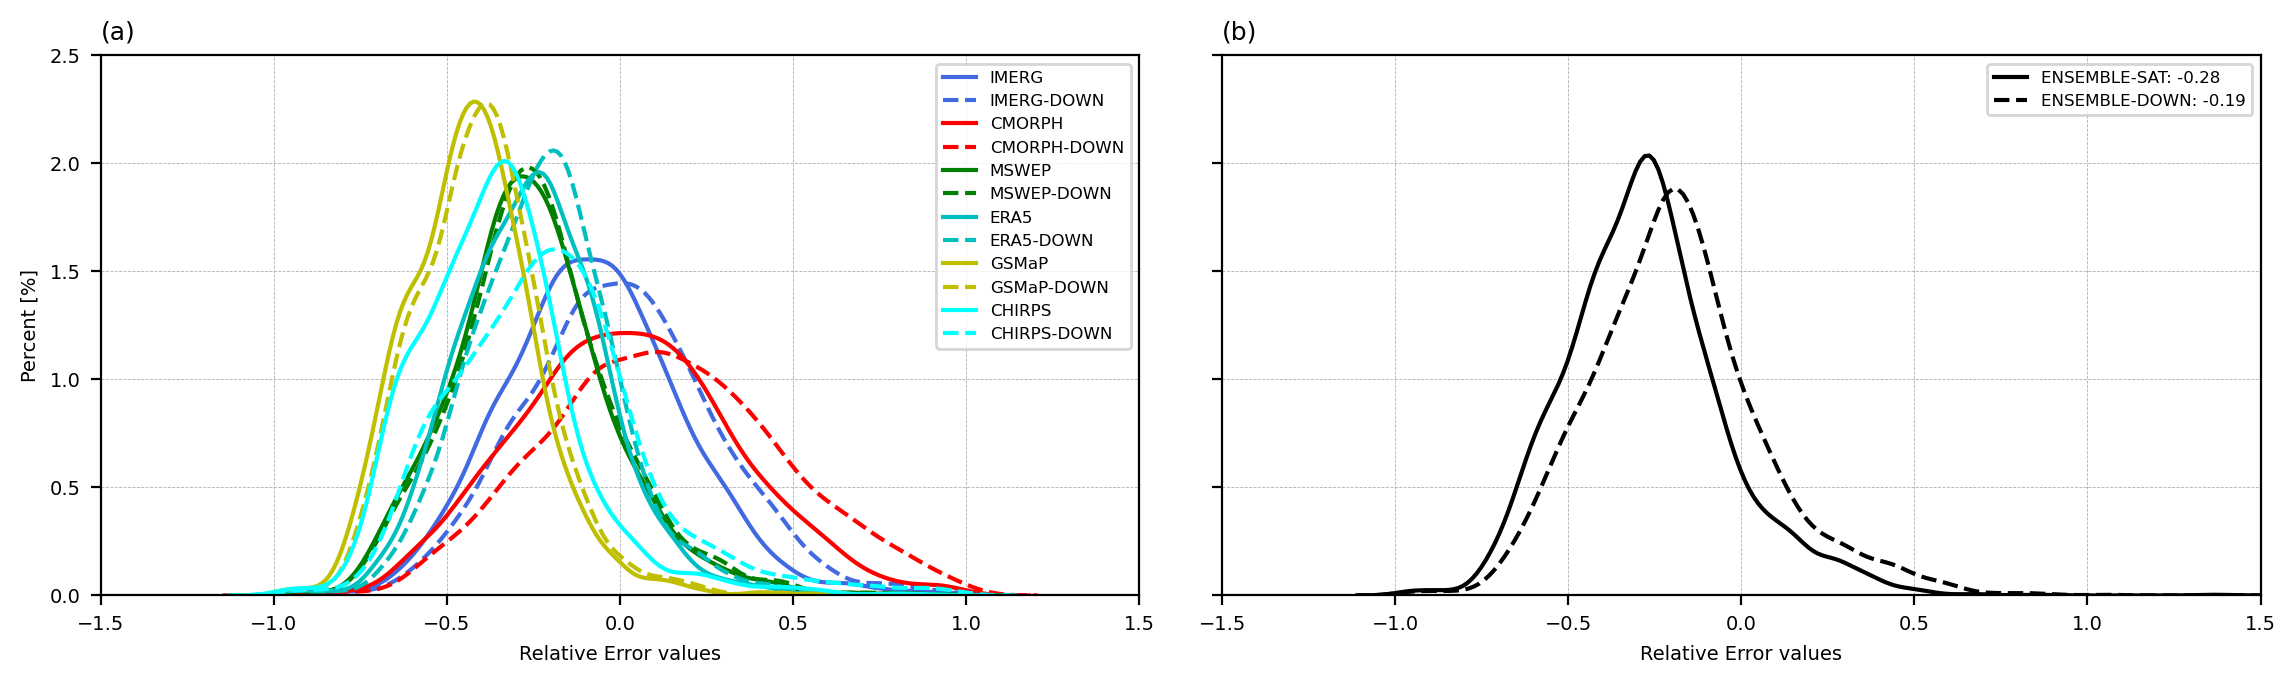

In [21]:
fig = plt.figure(figsize=(12,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_SAT_RE_M,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_DOWN_RE_M,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG-DOWN')

sns.kdeplot(CMORPH_SAT_RE_M,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_DOWN_RE_M,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH-DOWN')

sns.kdeplot(MSWEP_SAT_RE_M,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_DOWN_RE_M,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP-DOWN')

sns.kdeplot(ERA5_SAT_RE_M,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_DOWN_RE_M,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5-DOWN')

sns.kdeplot(GSMaP_SAT_RE_M,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_DOWN_RE_M,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP-DOWN')

sns.kdeplot(CHIRPS_SAT_RE_M,color=colors[7],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS')
sns.kdeplot(CHIRPS_DOWN_RE_M,color=colors[7], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS-DOWN')

# sns.kdeplot(SAT_RE_M,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-SAT')
# sns.kdeplot(DOWN_RE_M,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-DOWN')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'(a)',fontsize=9, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])

sns.kdeplot(ENSEMBLE_SAT_RE_M,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-SAT: {np.round(np.nanmean(ENSEMBLE_SAT_RE_M),2)}')
sns.kdeplot(ENSEMBLE_DOWN_RE_M,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-DOWN: {np.round(np.nanmean(ENSEMBLE_DOWN_RE_M),2)}')

ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=6, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.set_yticklabels('')
ax1.set_ylabel('')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title(f'(b)',fontsize=9, loc='left')

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.08, hspace=0.15)

salida = '../figures/Article_down/Products_DOWN_RE_dist_median.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

## Quantiles Statistics

In [22]:
labels = ["IMERG", "CMORPH", "MSWEP", "ERA5", "GSMaP", "CHIRPS", "ENSEMBLE"]

In [23]:
CMORPH_SAT_RE_M = CMORPH_SAT_RE_M[~np.isnan(CMORPH_SAT_RE_M)]
ERA5_SAT_RE_M = ERA5_SAT_RE_M[~np.isnan(ERA5_SAT_RE_M)]
GSMaP_SAT_RE_M = GSMaP_SAT_RE_M[~np.isnan(GSMaP_SAT_RE_M)]
MSWEP_SAT_RE_M = MSWEP_SAT_RE_M[~np.isnan(MSWEP_SAT_RE_M)]
IMERG_SAT_RE_M = IMERG_SAT_RE_M[~np.isnan(IMERG_SAT_RE_M)]
CHIRPS_SAT_RE_M = CHIRPS_SAT_RE_M[~np.isnan(CHIRPS_SAT_RE_M)]
ENSEMBLE_SAT_RE_M = ENSEMBLE_SAT_RE_M[~np.isnan(ENSEMBLE_SAT_RE_M)]

CMORPH_DOWN_RE_M = CMORPH_DOWN_RE_M[~np.isnan(CMORPH_DOWN_RE_M)]
ERA5_DOWN_RE_M = ERA5_DOWN_RE_M[~np.isnan(ERA5_DOWN_RE_M)]
GSMaP_DOWN_RE_M = GSMaP_DOWN_RE_M[~np.isnan(GSMaP_DOWN_RE_M)]
MSWEP_DOWN_RE_M = MSWEP_DOWN_RE_M[~np.isnan(MSWEP_DOWN_RE_M)]
IMERG_DOWN_RE_M = IMERG_DOWN_RE_M[~np.isnan(IMERG_DOWN_RE_M)]
CHIRPS_DOWN_RE_M = CHIRPS_DOWN_RE_M[~np.isnan(CHIRPS_DOWN_RE_M)]
ENSEMBLE_DOWN_RE_M = ENSEMBLE_DOWN_RE_M[~np.isnan(ENSEMBLE_DOWN_RE_M)]

In [24]:
## METRICS FOR QUANTILES
SAT_rmse = np.array([
                np.round(np.sqrt(np.mean((IMERG_SAT_Q50_VAL - IMERG_SAT_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((CMORPH_SAT_Q50_VAL - CMORPH_SAT_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((MSWEP_SAT_Q50_VAL - MSWEP_SAT_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((ERA5_SAT_Q50_VAL - ERA5_SAT_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((GSMaP_SAT_Q50_VAL - GSMaP_SAT_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((CHIRPS_SAT_Q50_VAL - CHIRPS_SAT_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((ENSEMBLE_SAT_Q50_VAL - ENSEMBLE_SAT_Q50_OBS)**2)),2)
                ])

SAT_corrs = np.array([
    np.round(np.corrcoef(IMERG_SAT_Q50_VAL,IMERG_SAT_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(CMORPH_SAT_Q50_VAL,CMORPH_SAT_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(MSWEP_SAT_Q50_VAL,MSWEP_SAT_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(ERA5_SAT_Q50_VAL,ERA5_SAT_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(GSMaP_SAT_Q50_VAL,GSMaP_SAT_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(CHIRPS_SAT_Q50_VAL,CHIRPS_SAT_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(ENSEMBLE_SAT_Q50_VAL,ENSEMBLE_SAT_Q50_OBS)[0, 1],2),
])

## METRICS FOR ERRORS
SAT_std = np.array([
                np.round(np.std(IMERG_SAT_RE_M),2),
                np.round(np.std(CMORPH_SAT_RE_M),2), 
                np.round(np.std(MSWEP_SAT_RE_M),2),
                np.round(np.std(ERA5_SAT_RE_M),2), 
                np.round(np.std(GSMaP_SAT_RE_M),2),
                np.round(np.std(CHIRPS_SAT_RE_M),2),
                np.round(np.std(ENSEMBLE_SAT_RE_M),2)
                ])

SAT_mean = np.array([
    np.round(np.nanmean(IMERG_SAT_RE_M),3),
    np.round(np.nanmean(CMORPH_SAT_RE_M),3),
    np.round(np.nanmean(MSWEP_SAT_RE_M),3),
    np.round(np.nanmean(ERA5_SAT_RE_M),3),
    np.round(np.nanmean(GSMaP_SAT_RE_M),3),
    np.round(np.nanmean(CHIRPS_SAT_RE_M),3),
    np.round(np.nanmean(ENSEMBLE_SAT_RE_M),3),
])

SAT_median = np.array([
    np.round(np.nanmedian(IMERG_SAT_RE_M),3),
    np.round(np.nanmedian(CMORPH_SAT_RE_M),3),
    np.round(np.nanmedian(MSWEP_SAT_RE_M),3),
    np.round(np.nanmedian(ERA5_SAT_RE_M),3),
    np.round(np.nanmedian(GSMaP_SAT_RE_M),3),
    np.round(np.nanmedian(CHIRPS_SAT_RE_M),3),
    np.round(np.nanmedian(ENSEMBLE_SAT_RE_M),3),
])

SAT_diff = abs(SAT_mean - SAT_median)

SAT_IQ = np.array([
    np.round(np.nanpercentile(IMERG_SAT_RE_M, 75) - np.nanpercentile(IMERG_SAT_RE_M, 25),2),
    np.round(np.nanpercentile(CMORPH_SAT_RE_M, 75) - np.nanpercentile(CMORPH_SAT_RE_M, 25),2),
    np.round(np.nanpercentile(MSWEP_SAT_RE_M, 75) - np.nanpercentile(MSWEP_SAT_RE_M, 25),2),
    np.round(np.nanpercentile(ERA5_SAT_RE_M, 75) - np.nanpercentile(ERA5_SAT_RE_M, 25),2),
    np.round(np.nanpercentile(GSMaP_SAT_RE_M, 75) - np.nanpercentile(GSMaP_SAT_RE_M, 25),2),
    np.round(np.nanpercentile(CHIRPS_SAT_RE_M, 75) - np.nanpercentile(CHIRPS_SAT_RE_M, 25),2),
    np.round(np.nanpercentile(ENSEMBLE_SAT_RE_M, 75) - np.nanpercentile(ENSEMBLE_SAT_RE_M, 25),2),
])

In [25]:
RSR_SAT_compare = pd.DataFrame({
    "Dataset": labels,
    "STD": SAT_std,
    "Mean": SAT_mean,
    "Median": SAT_median,
    "DIFF":SAT_diff,
    "IQR": SAT_IQ,
    "CORR": SAT_corrs,
    "RMSE": SAT_rmse,
})

In [26]:
## METRICS FOR QUANTILES
DOWN_rmse = np.array([
                np.round(np.sqrt(np.mean((IMERG_DOWN_Q50_VAL - IMERG_DOWN_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((CMORPH_DOWN_Q50_VAL - CMORPH_DOWN_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((MSWEP_DOWN_Q50_VAL - MSWEP_DOWN_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((ERA5_DOWN_Q50_VAL - ERA5_DOWN_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((GSMaP_DOWN_Q50_VAL - GSMaP_DOWN_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((CHIRPS_DOWN_Q50_VAL - CHIRPS_DOWN_Q50_OBS)**2)),2),
                np.round(np.sqrt(np.mean((ENSEMBLE_DOWN_Q50_VAL - ENSEMBLE_DOWN_Q50_OBS)**2)),2)
                ])

DOWN_corrs = np.array([
    np.round(np.corrcoef(IMERG_DOWN_Q50_VAL,IMERG_DOWN_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(CMORPH_DOWN_Q50_VAL,CMORPH_DOWN_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(MSWEP_DOWN_Q50_VAL,MSWEP_DOWN_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(ERA5_DOWN_Q50_VAL,ERA5_DOWN_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(GSMaP_DOWN_Q50_VAL,GSMaP_DOWN_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(CHIRPS_DOWN_Q50_VAL,CHIRPS_DOWN_Q50_OBS)[0, 1],2),
    np.round(np.corrcoef(ENSEMBLE_DOWN_Q50_VAL,ENSEMBLE_DOWN_Q50_OBS)[0, 1],2),
])

## METRICS FOR ERRORS
DOWN_std = np.array([
                np.round(np.std(IMERG_DOWN_RE_M),2),
                np.round(np.std(CMORPH_DOWN_RE_M),2), 
                np.round(np.std(MSWEP_DOWN_RE_M),2),
                np.round(np.std(ERA5_DOWN_RE_M),2), 
                np.round(np.std(GSMaP_DOWN_RE_M),2),
                np.round(np.std(CHIRPS_DOWN_RE_M),2),
                np.round(np.std(ENSEMBLE_DOWN_RE_M),2)
                ])

DOWN_mean = np.array([
    np.round(np.nanmean(IMERG_DOWN_RE_M),3),
    np.round(np.nanmean(CMORPH_DOWN_RE_M),3),
    np.round(np.nanmean(MSWEP_DOWN_RE_M),3),
    np.round(np.nanmean(ERA5_DOWN_RE_M),3),
    np.round(np.nanmean(GSMaP_DOWN_RE_M),3),
    np.round(np.nanmean(CHIRPS_DOWN_RE_M),3),
    np.round(np.nanmean(ENSEMBLE_DOWN_RE_M),3),
])

DOWN_median = np.array([
    np.round(np.nanmedian(IMERG_DOWN_RE_M),3),
    np.round(np.nanmedian(CMORPH_DOWN_RE_M),3),
    np.round(np.nanmedian(MSWEP_DOWN_RE_M),3),
    np.round(np.nanmedian(ERA5_DOWN_RE_M),3),
    np.round(np.nanmedian(GSMaP_DOWN_RE_M),3),
    np.round(np.nanmedian(CHIRPS_DOWN_RE_M),3),
    np.round(np.nanmedian(ENSEMBLE_DOWN_RE_M),3),
])

DOWN_diff = abs(DOWN_mean - DOWN_median)

DOWN_IQ = np.array([
    np.round(np.nanpercentile(IMERG_DOWN_RE_M, 75) - np.nanpercentile(IMERG_DOWN_RE_M, 25),2),
    np.round(np.nanpercentile(CMORPH_DOWN_RE_M, 75) - np.nanpercentile(CMORPH_DOWN_RE_M, 25),2),
    np.round(np.nanpercentile(MSWEP_DOWN_RE_M, 75) - np.nanpercentile(MSWEP_DOWN_RE_M, 25),2),
    np.round(np.nanpercentile(ERA5_DOWN_RE_M, 75) - np.nanpercentile(ERA5_DOWN_RE_M, 25),2),
    np.round(np.nanpercentile(GSMaP_DOWN_RE_M, 75) - np.nanpercentile(GSMaP_DOWN_RE_M, 25),2),
    np.round(np.nanpercentile(CHIRPS_DOWN_RE_M, 75) - np.nanpercentile(CHIRPS_DOWN_RE_M, 25),2),
    np.round(np.nanpercentile(ENSEMBLE_DOWN_RE_M, 75) - np.nanpercentile(ENSEMBLE_DOWN_RE_M, 25),2),
])

In [27]:
RSR_DOWN_compare = pd.DataFrame({
    "Dataset": labels,
    "STD": DOWN_std,
    "Mean": DOWN_mean,
    "Median": DOWN_median,
    "DIFF":DOWN_diff,
    "IQR": DOWN_IQ,
    "CORR": DOWN_corrs,
    "RMSE": DOWN_rmse,
})

In [28]:
RSR_SAT_compare

Dataset   STD   Mean  Median   DIFF   IQR  CORR   RMSE
0     IMERG  0.26 -0.075  -0.082  0.007  0.34  0.61  59.83
1    CMORPH  0.31  0.020   0.011  0.009  0.42  0.50  59.62
2     MSWEP  0.23 -0.254  -0.267  0.013  0.27  0.59  73.44
3      ERA5  0.21 -0.252  -0.254  0.002  0.28  0.59  73.64
4     GSMaP  0.19 -0.425  -0.430  0.005  0.24  0.43  98.84
5    CHIRPS  0.23 -0.357  -0.362  0.005  0.27  0.41  90.52
6  ENSEMBLE  0.23 -0.276  -0.283  0.007  0.27  0.50  79.18

In [29]:
RSR_DOWN_compare

Dataset   STD   Mean  Median   DIFF   IQR  CORR   RMSE
0     IMERG  0.28 -0.000  -0.003  0.003  0.36  0.61  55.72
1    CMORPH  0.34  0.124   0.116  0.008  0.47  0.50  60.05
2     MSWEP  0.24 -0.242  -0.257  0.015  0.28  0.59  72.22
3      ERA5  0.21 -0.219  -0.219  0.000  0.26  0.63  69.40
4     GSMaP  0.19 -0.399  -0.403  0.004  0.24  0.43  98.28
5    CHIRPS  0.28 -0.206  -0.218  0.012  0.34  0.40  75.88
6  ENSEMBLE  0.25 -0.186  -0.200  0.014  0.29  0.52  70.06

Text(0.5, 1, 'Correlation')

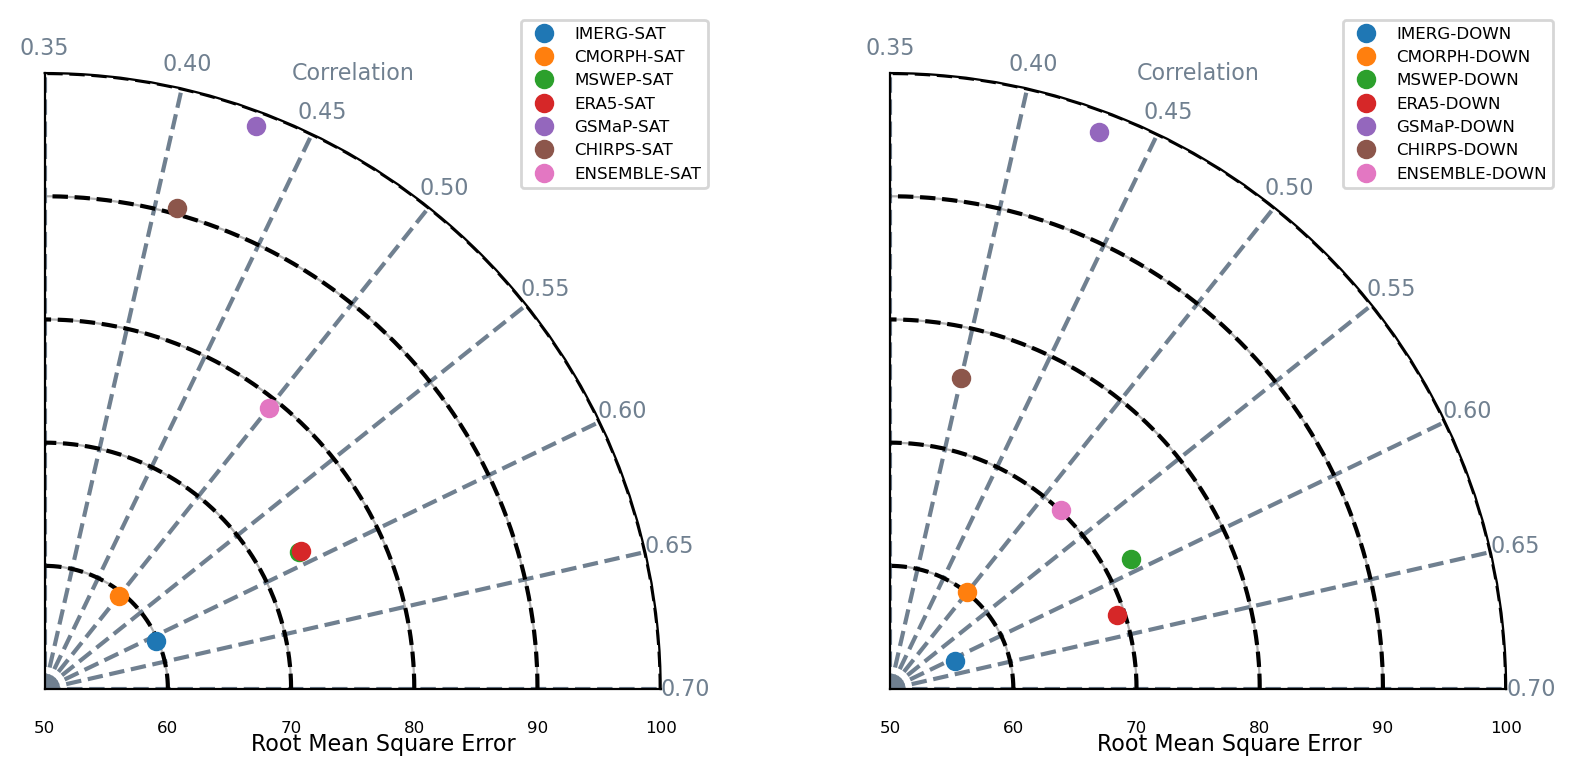

In [40]:
fig = plt.figure(figsize=(10,4),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax = plt.subplot(gs[0, 0], polar=True)

rmin = 50
rmax = 100

c_min = 0.35
c_max = 0.7
correlations = np.arange(0.35, 0.75, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax.text(theta, rmax * 1.02, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE RMSE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab in zip(SAT_rmse, SAT_corrs, labels):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax.plot(theta, rmse_val, 'o', markersize=6, label=f'{lab}-SAT')

# --- LÍMITES Y DIRECCIÓN ---
ax.set_thetamin(0)
ax.set_thetamax(90)
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_rmin(rmin)
ax.set_rmax(rmax)

# --- RADIAL TICKS ---
ax.set_yticks(radial_ticks)
ax.tick_params(axis='both', which='major', labelsize=6, pad=8)

ax.grid(True)

plt.legend(fontsize=6, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.1))

# --- LABELS ---
ax.text(0.55, -0.09, "Root Mean Square Error", transform=ax.transAxes,
        ha="center", va="center", fontsize=8)

ax.text(0.5, 1, "Correlation", transform=ax.transAxes,
        ha="center", va="center", rotation=0, fontsize=8, color='slategrey')

# =========================================================================================================================
ax = plt.subplot(gs[0, 1], polar=True)

rmin = 50
rmax = 100

c_min = 0.35
c_max = 0.7
correlations = np.arange(0.35, 0.75, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax.text(theta, rmax * 1.02, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE RMSE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab in zip(DOWN_rmse, DOWN_corrs, labels):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    ax.plot(theta, rmse_val, 'o', markersize=6, label=f'{lab}-DOWN')

# --- LÍMITES Y DIRECCIÓN ---
ax.set_thetamin(0)
ax.set_thetamax(90)
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_rmin(rmin)
ax.set_rmax(rmax)

# --- RADIAL TICKS ---
ax.set_yticks(radial_ticks)
ax.tick_params(axis='both', which='major', labelsize=6, pad=8)

ax.grid(True)

plt.legend(fontsize=6, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.1))

# --- LABELS ---
ax.text(0.55, -0.09, "Root Mean Square Error", transform=ax.transAxes,
        ha="center", va="center", fontsize=8)

ax.text(0.5, 1, "Correlation", transform=ax.transAxes,
        ha="center", va="center", rotation=0, fontsize=8, color='slategrey')

../figures/Article_down/Products_DOWN_RE_dist_taylor.png


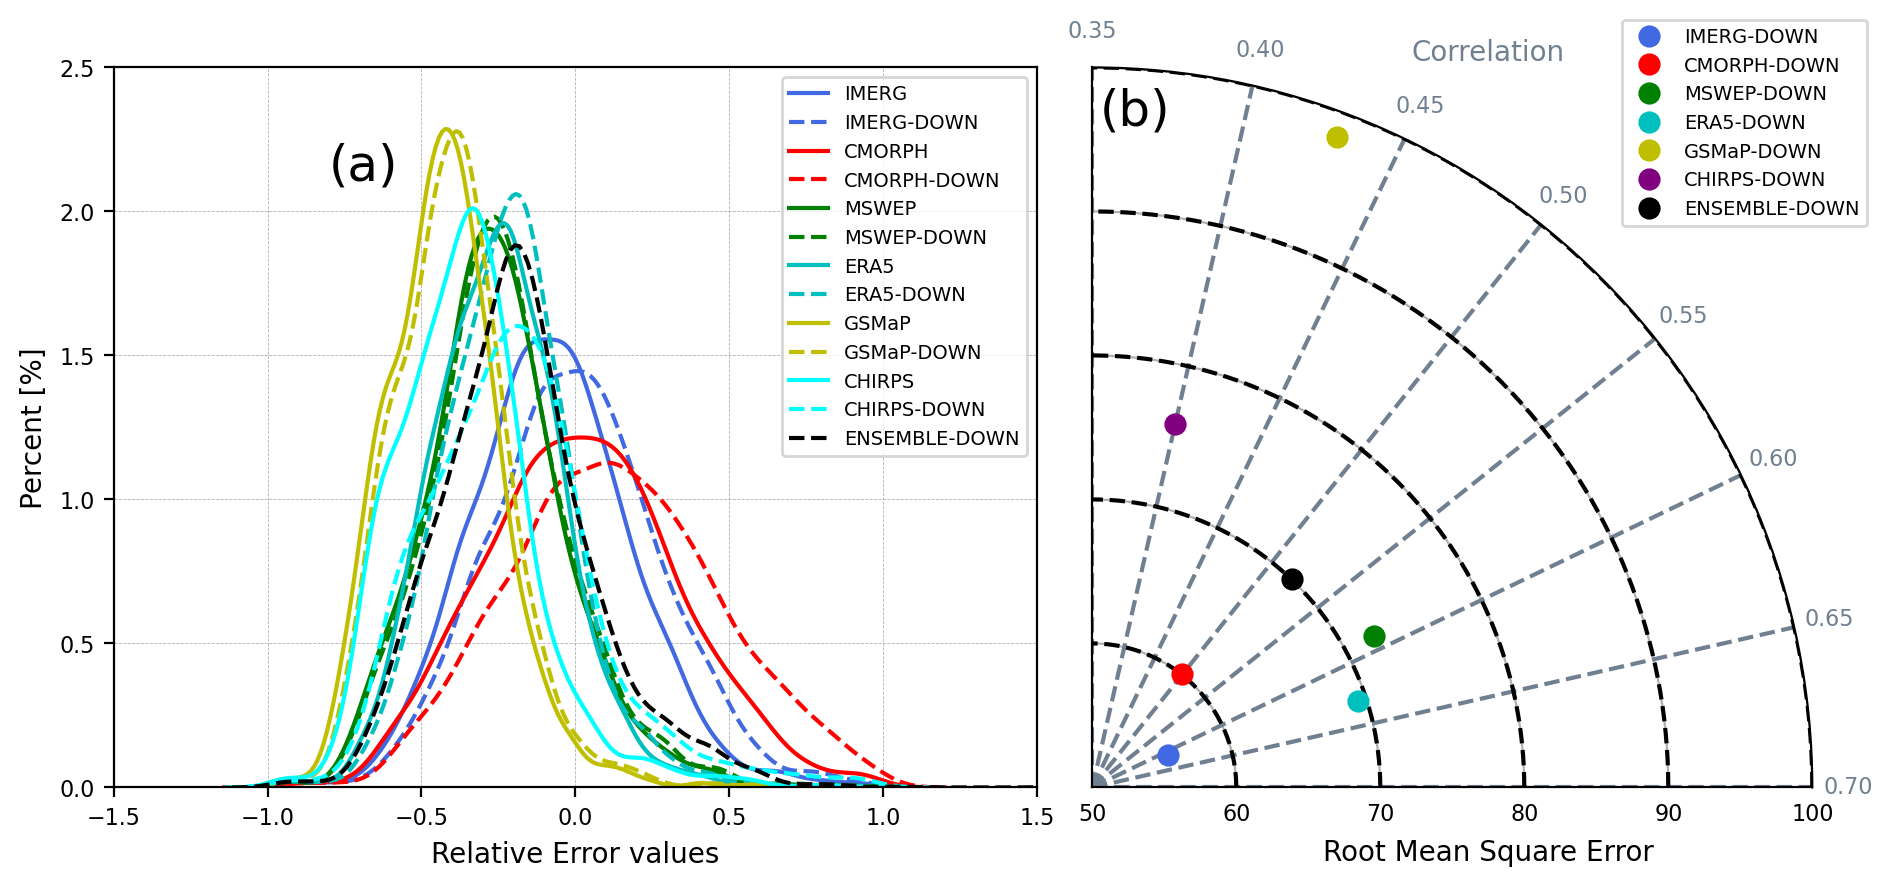

In [43]:
fig = plt.figure(figsize=(10,4),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_SAT_RE_M,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(IMERG_DOWN_RE_M,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG-DOWN')

sns.kdeplot(CMORPH_SAT_RE_M,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(CMORPH_DOWN_RE_M,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH-DOWN')

sns.kdeplot(MSWEP_SAT_RE_M,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(MSWEP_DOWN_RE_M,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP-DOWN')

sns.kdeplot(ERA5_SAT_RE_M,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(ERA5_DOWN_RE_M,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5-DOWN')

sns.kdeplot(GSMaP_SAT_RE_M,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(GSMaP_DOWN_RE_M,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP-DOWN')

sns.kdeplot(CHIRPS_SAT_RE_M,color=colors[7],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS')
sns.kdeplot(CHIRPS_DOWN_RE_M,color=colors[7], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CHIRPS-DOWN')

sns.kdeplot(ENSEMBLE_DOWN_RE_M,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-DOWN')
# sns.kdeplot(SAT_RE_M,color='k', linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-SAT')

ax1.set_ylabel('Percent [%]',fontsize=10)
ax1.set_xlabel('Relative Error values',fontsize=10)
ax1.legend(fontsize=7, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,2.5)
ax1.tick_params(axis='both', which='major', labelsize=8)

ax1.text(-1.26, 1.03, "(a)", transform=ax.transAxes,
        ha="center", va="center", rotation=0, fontsize=18, color='k')

# =========================================================================================================================
ax = plt.subplot(gs[0, 1], polar=True)

rmin = 50
rmax = 100

c_min = 0.35
c_max = 0.7
correlations = np.arange(0.35, 0.75, 0.05)

for c in correlations:
    theta = (c_max - c) / (c_max - c_min) * (np.pi/2)
    ax.plot([theta, theta], [rmin, rmax], color="slategrey", linestyle="--")
    ax.text(theta, rmax * 1.025, f"{c:.2f}", ha="center", va="center",
            fontsize=8, color="slategrey")

# --- NUEVOS CÍRCULOS RADIALES DE RMSE ---
radial_ticks = np.linspace(rmin, rmax, 6)
for r in radial_ticks:
    ax.plot(np.linspace(0, np.pi/2, 200), np.ones(200)*r, color="k", linestyle="--")

# --- LIMPIEZA DE EJE ANGULAR ---
ax.xaxis.set_visible(False)

# --- PUNTOS DE MODELOS ---
for rmse_val, corr_val, lab, co in zip(DOWN_rmse, DOWN_corrs, labels, colors):
    theta = (c_max - corr_val) / (c_max - c_min) * (np.pi/2)
    if lab == 'ENSEMBLE':
        ax.plot(theta, rmse_val, 'o', markersize=7, label=f'{lab}-DOWN', color='k')
    else:
        ax.plot(theta, rmse_val, 'o', markersize=7, label=f'{lab}-DOWN', color=co)

# --- LÍMITES Y DIRECCIÓN ---
ax.set_thetamin(0)
ax.set_thetamax(90)
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_rmin(rmin)
ax.set_rmax(rmax)

# --- RADIAL TICKS ---
ax.set_yticks(radial_ticks)
ax.tick_params(axis='both', which='major', labelsize=8, pad=2)
ax.grid(True)

plt.legend(fontsize=7, ncol=1, loc='upper right', bbox_to_anchor=(1.09, 1.08))

# --- LABELS ---
ax.text(0.55, -0.09, "Root Mean Square Error", transform=ax.transAxes,
        ha="center", va="center", fontsize=10)

ax.text(0.55, 1.02, "Correlation", transform=ax.transAxes,
        ha="center", va="center", rotation=0, fontsize=10, color='slategrey')

ax.text(0.06, 0.94, "(b)", transform=ax.transAxes,
        ha="center", va="center", rotation=0, fontsize=18, color='k')

# ============================================================================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=-0.05, hspace=-0.2)

salida = f'../figures/Article_down/Products_DOWN_RE_dist_taylor.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)